# Помесячный прогноз средней заработной платы в России в 2016-2018гг.
*Имеются статистические данные о средней заработной платы в России с января 1993 по август 2016.
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.*

In [1]:
#%pylab inline
%matplotlib inline 
#%matplotlib notebook
from collections import namedtuple
import datetime
from dateutil.relativedelta import relativedelta
from itertools import product
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from scipy.stats import ttest_1samp
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
SIZE_OF_PLOTS = (15,8)

In [3]:
def show_plot(x,y,*, 
              xlabel='Date, [year]', 
              ylabel='Average salary, [rub]', 
              title='Average salary in russia per month'):
    fig, ax = plt.subplots(figsize=SIZE_OF_PLOTS)
    ax.plot(x, y)
    ax.set(xlabel = xlabel, 
           ylabel = ylabel, 
           title = title)
    ax.grid()
    plt.show()

In [4]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

## Визуальный анализ ряда

In [5]:
df_avrge_slry = pd.read_csv('WAG-average-salary-in-russia.csv', 
                            sep=';', 
                            index_col=['month'], 
                            parse_dates=['month'], 
                            dayfirst=True,
                           )
df_avrge_slry.head(3)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6


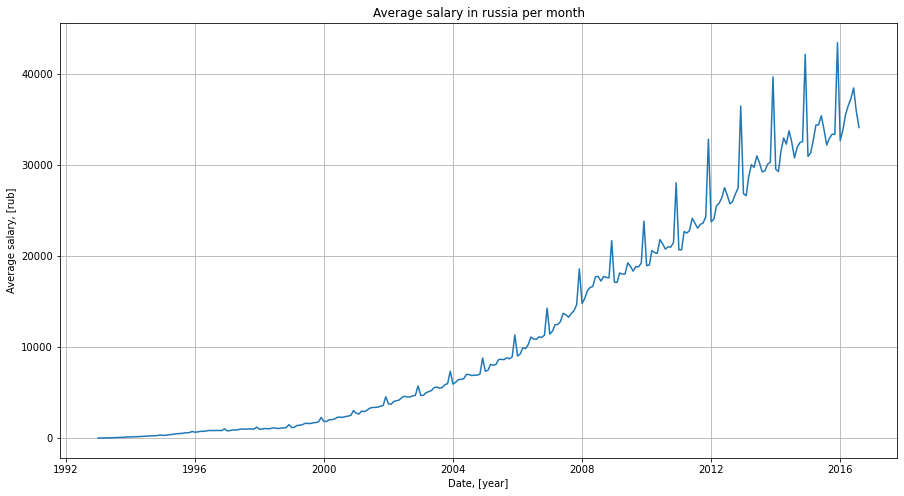

In [6]:
show_plot(df_avrge_slry.index, 
          df_avrge_slry.WAG_C_M, 
         )

Ддя сравнения данные Федеральнаой службы государственной статистики за 1991-2020 гг
https://www.gks.ru/storage/mediabank/t1.docx

In [7]:
class Sesonal_decomposition():
    def __init__(self, df_ser):
        self.decomposed_result = seasonal_decompose(df_ser, period=12)
        self.attributes = {
            "Seasonal": {
                "index": self.decomposed_result.seasonal.index,
                "data": self.decomposed_result.seasonal,
                "ylabel": 'Seasonal, [rub]',
                "title": 'The seasonal component of the average salary',
            },
            "Trend": {
                "index": self.decomposed_result.trend.index,
                "data": self.decomposed_result.trend,
                "ylabel": 'Trend, [rub]',
                "title": 'The trend component of the average salary',
            }, 
            "Residual": {
                "index": self.decomposed_result.resid.index,
                "data": self.decomposed_result.resid,
                "ylabel": 'Residual, [rub]',
                "title": 'The residual component of the average salary',
            },
            "Weights": {
                "index": self.decomposed_result.weights.index,
                "data": self.decomposed_result.weights,
                "ylabel": 'Weights',
                "title": 'The weights used to reduce outlier influence',
            },
        }
    
    def plot(self):
        for s_plt in self.attributes.values():
            show_plot(s_plt["index"],
                      s_plt["data"],
                      ylabel=s_plt["ylabel"],
                      title=s_plt["title"],
                      )
    def __str__(self):
        return str(self.attributes)

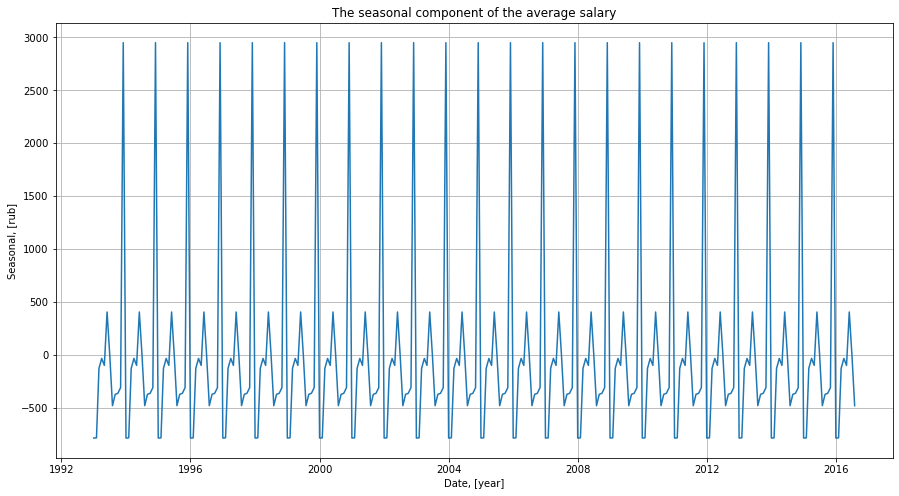

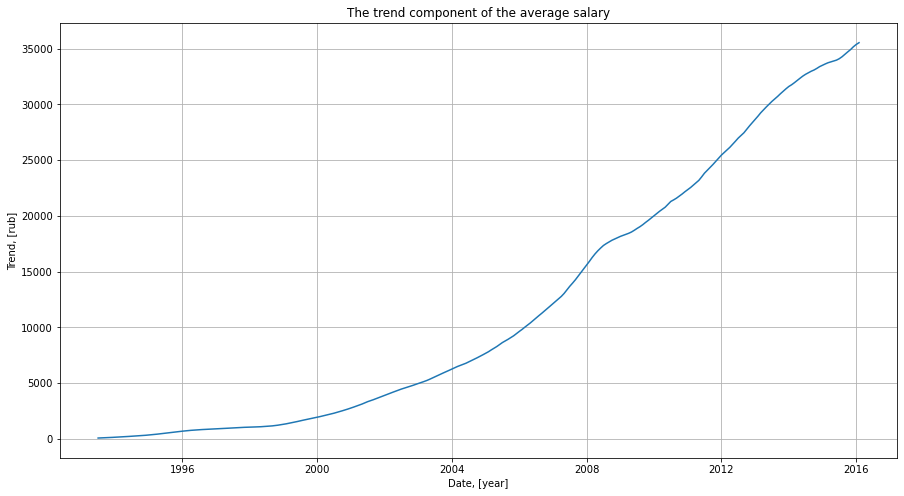

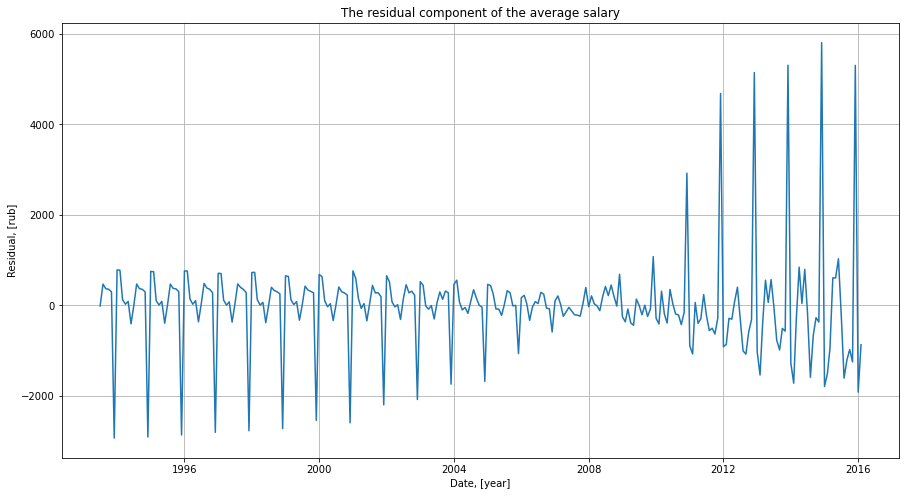

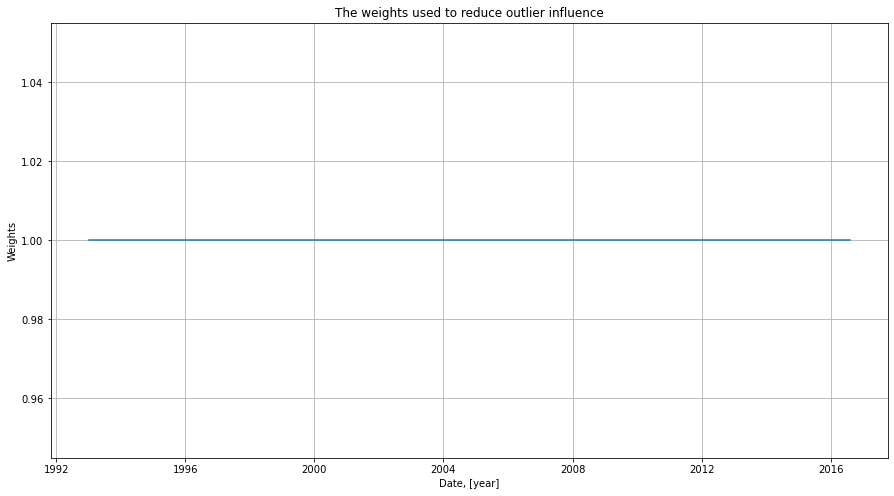

In [8]:
Sesonal_decomp = Sesonal_decomposition(df_avrge_slry.WAG_C_M)
Sesonal_decomp.plot()

Из графиков видны: наличие тренда (см. The trend component of the average salary) и нестохастичносить остатков (см. The residual component of the average salary).<br> 
Наличие тренда говорит нам о нестационарности.
Проведём Unit root test, используя augmented Dickey-Fuller test (adf) и MacKinnon's p-values.<br> 
H<sub>0</sub>: ряд нестационарен.


In [9]:
print(f"Критерий Дики-Фуллера: p = {adfuller(df_avrge_slry.WAG_C_M)[1]:.6f}")

Критерий Дики-Фуллера: p = 0.991850


## Стабилизация дисперсии (при необходимости)

Поскольку дисперсия увеличивается со временим, требуется применить преобразование Бокса-Кокса.

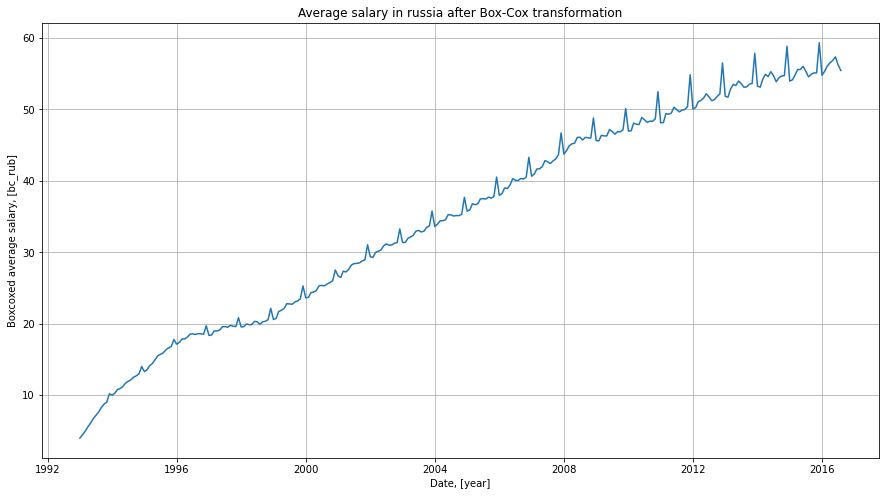

In [10]:
df_avrge_slry["boxcox_WAG"], boxcox_lambda  = boxcox(df_avrge_slry.WAG_C_M)
show_plot(df_avrge_slry.index, 
          df_avrge_slry["boxcox_WAG"],
          ylabel='Boxcoxed average salary, [bc_rub]', 
          title='Average salary in russia after Box-Cox transformation')

In [11]:
print(f"Критерий Дики-Фуллера: p = {adfuller(df_avrge_slry.boxcox_WAG)[1]:.6f}", 
      f"Оптимальный параметр преобразования Бокса-Кокса = {boxcox_lambda:.6f}", sep = "\n")

Критерий Дики-Фуллера: p = 0.696899
Оптимальный параметр преобразования Бокса-Кокса = 0.263202


## Выбор порядка дифференцирования

Применяем сезонное диференцирование, с целью - сделать ряд стационарым

In [12]:
df_avrge_slry['salary_box_diff12m'] = df_avrge_slry.boxcox_WAG - df_avrge_slry.boxcox_WAG.shift(12)

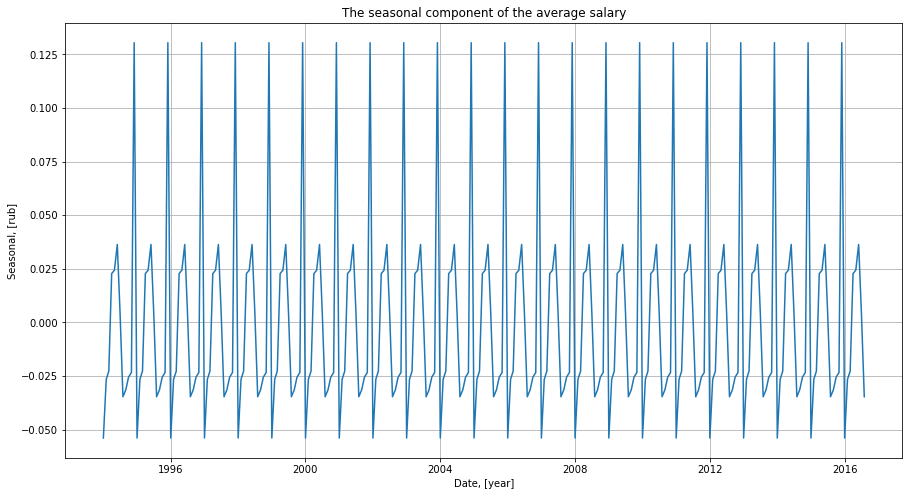

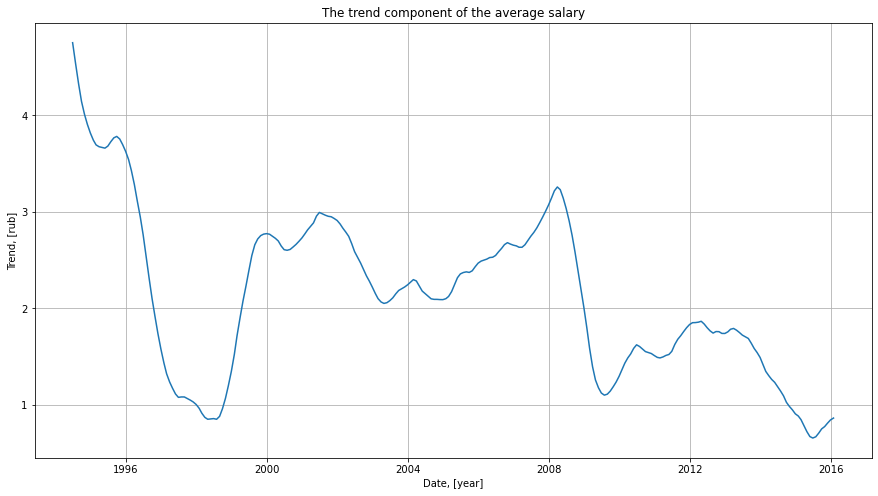

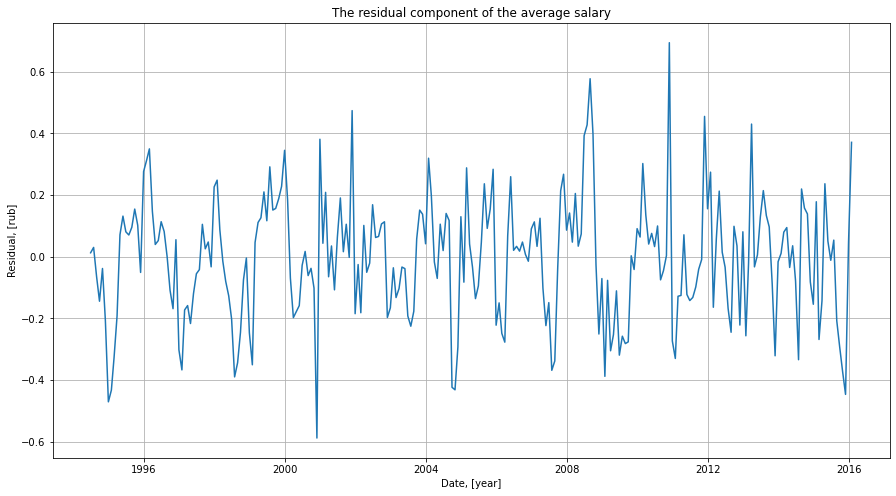

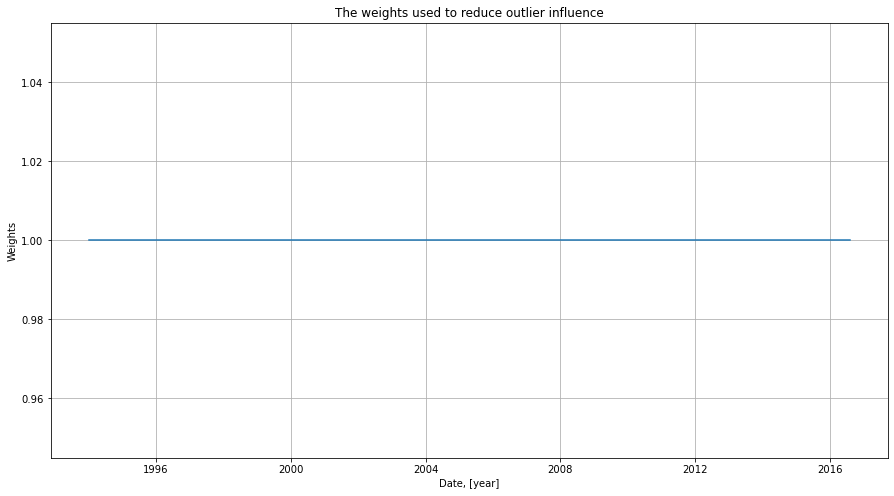

In [13]:
sesonal_diff12_decomp = Sesonal_decomposition(df_avrge_slry.salary_box_diff12m[12:])
sesonal_diff12_decomp.plot()

In [14]:
print(f"Критерий Дики-Фуллера: p={adfuller(df_avrge_slry.salary_box_diff12m.values[12:])[1]:.6f}")

Критерий Дики-Фуллера: p=0.014697


Хотя критерий Дики-Фуллера и 0.014697, на графике 'The trend component of the average salary', всё ещё виден тренд. Чтобы избавиться от него, применим обычное дифференцирование. 

In [15]:
df_avrge_slry['salary_box_diff12m_diff1m'] = df_avrge_slry.salary_box_diff12m - df_avrge_slry.salary_box_diff12m.shift(1)

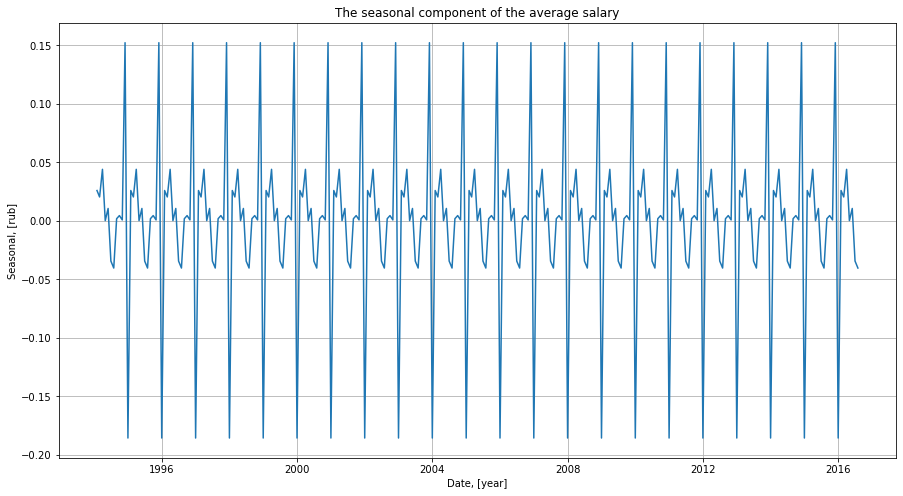

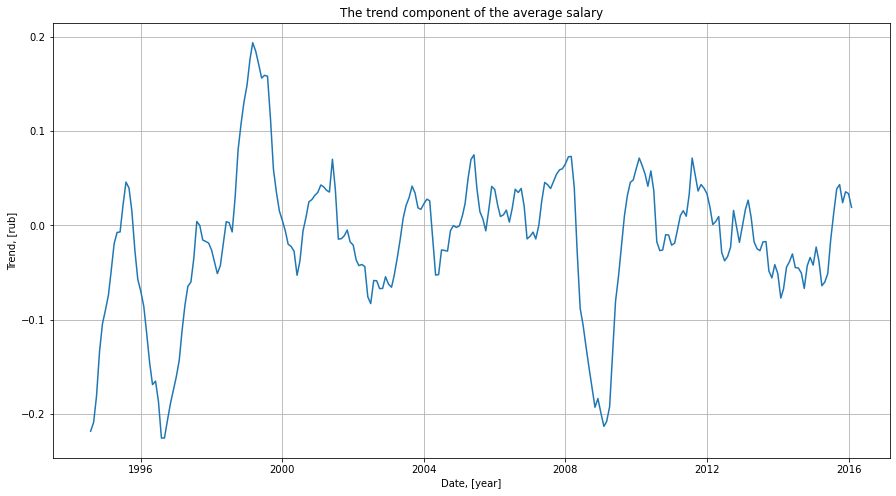

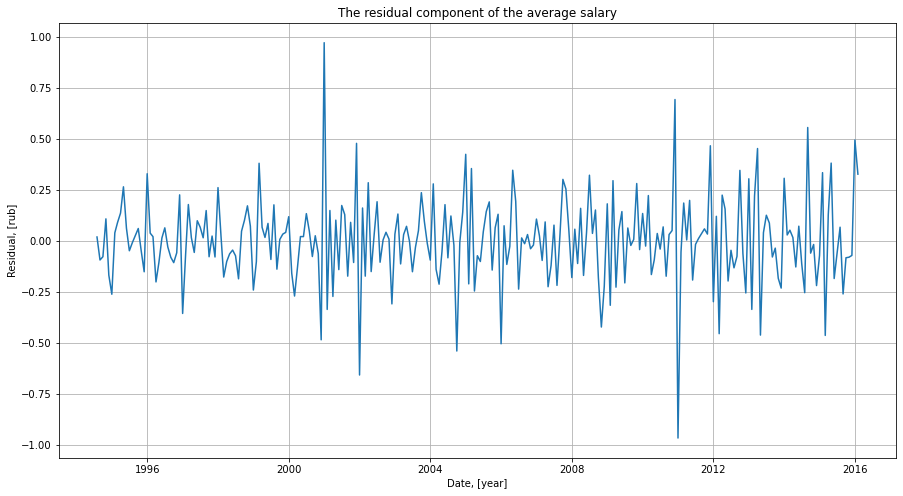

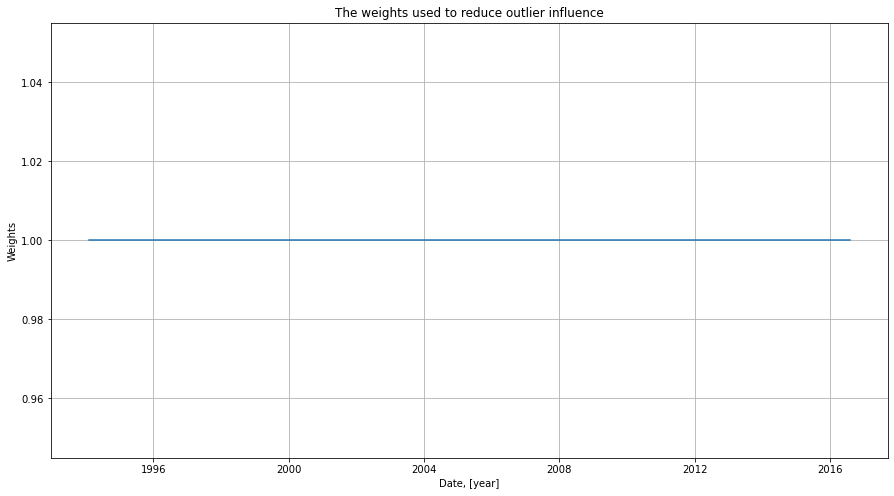

In [16]:
sesonal_diff12_diff1_decomp = Sesonal_decomposition(df_avrge_slry.salary_box_diff12m_diff1m[13:])
sesonal_diff12_diff1_decomp.plot()  

In [17]:
print(f"Критерий Дики-Фуллера: p = {adfuller(df_avrge_slry.salary_box_diff12m_diff1m.values[13:])[1]:.6}")

Критерий Дики-Фуллера: p = 5.2036e-08


Теперь мы уже можем отвергнуть гипотезу нестационарости временного ряда.

## Выбор начальных приближений для p,q,P,Q

Рассмотрим autocorrelation function (ACF) и partial autocorrelation function (PACF): 

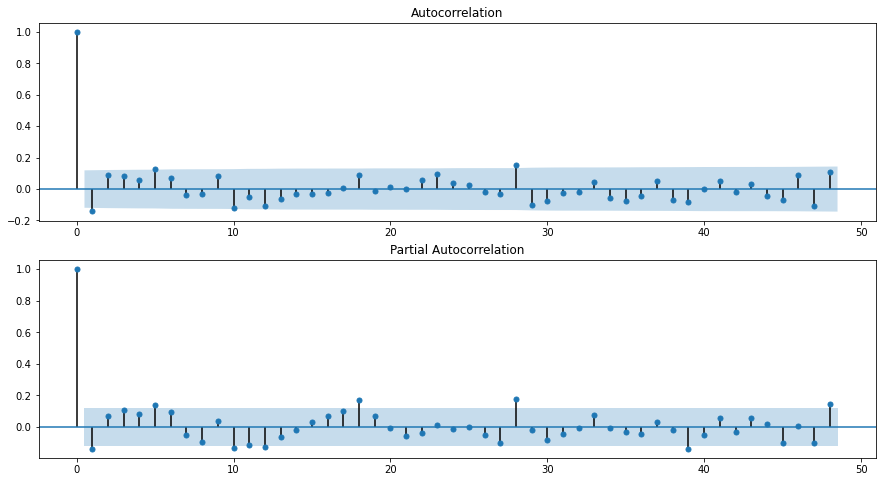

In [18]:
plt.figure(figsize = SIZE_OF_PLOTS)
ax = plt.subplot(211)
plot_acf(df_avrge_slry.salary_box_diff12m_diff1m.values[13:], lags=48, ax=ax)
ax = plt.subplot(212)
plot_pacf(df_avrge_slry.salary_box_diff12m_diff1m.values[13:], lags=48, ax=ax)
plt.show()

Гиперпараметры <b>Q, q</b> возьмем изходя из графика автокорреляции:
<ul>
    <li><b>Q*S</b> - номер последнего сезонного лага, при котором автокорреляция значима (здесь 0)</li>
    <li><b>q</b> - номер последнего несезонного лага, при котором автокорреляция значима (здесь 5)</li>
</ul>
<b>p, P</b> выберем по графику частичной автокорреляции:
<ul>
    <li><b>P*S</b> - номер последнего сезонного лага, при котором частичная автокорреляция значима (здесь 1)</li>
    <li><b>p</b> - номер последнего несезонного лага, при котором частичная автокорреляция значима (здесь 10)</li>
</ul>  

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [19]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [20]:
Prms = namedtuple("Prms", ["ps", "qs", "Ps", "Qs"])
named_params = [Prms(ps = prms[0], qs = prms[1], Ps = prms[2], Qs = prms[3]) for prms in 
                list(product(ps, qs, Ps, Qs))]
len(named_params)

132

### Обучение модели

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in named_params:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=SARIMAX(df_avrge_slry.boxcox_WAG.values, 
                      order=(param.ps, d, param.qs),
                      seasonal_order=(param.Ps, D, param.Qs, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3min 11s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic').head(10))

      parameters        aic
71  (5, 5, 1, 0) -25.090430
81  (6, 4, 1, 0) -24.835581
59  (4, 5, 1, 0) -23.862231
93  (7, 4, 1, 0) -23.019340
83  (6, 5, 1, 0) -22.627966
70  (5, 5, 0, 0) -22.316118
28  (2, 2, 0, 0) -21.488595
29  (2, 2, 1, 0) -21.473461
30  (2, 3, 0, 0) -21.091450
31  (2, 3, 1, 0) -20.398611


### Лучшая модель. Подробности.

In [23]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.545
Date:                             Sun, 30 Aug 2020   AIC                            -25.090
Time:                                     14:29:14   BIC                             18.135
Sample:                                          0   HQIC                            -7.735
                                             - 284                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.594     -0.371      0.711      -1.384       0.944
ar.L2          0.2427      

## Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q

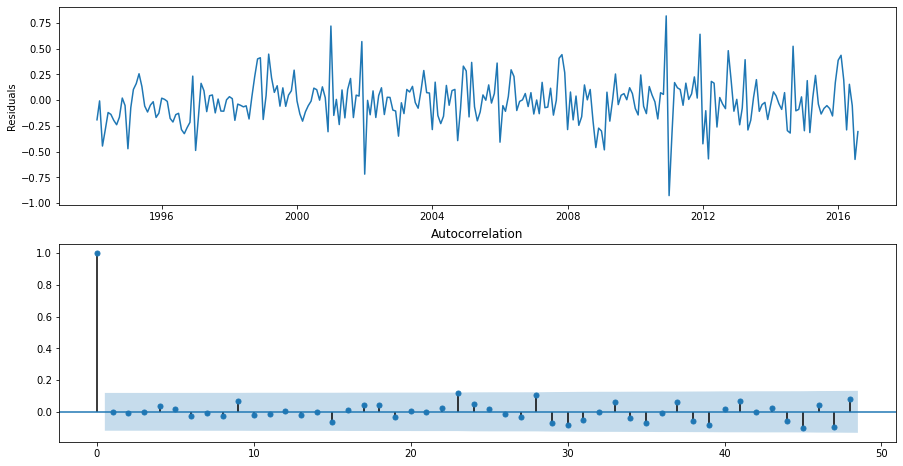

Критерий Стьюдента: p=0.162261
Критерий Дики-Фуллера: p=0.000000


In [24]:
plt.figure(figsize = SIZE_OF_PLOTS)
plt.subplot(211)
plt.plot(df_avrge_slry.index.values[13:], best_model.resid[13:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(best_model.resid[13:], lags=48, ax=ax)

plt.show()

print("Критерий Стьюдента: p=%f" % ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько модель подстроилась под даные

In [25]:
df_avrge_slry['model'] = invboxcox(best_model.fittedvalues, boxcox_lambda)

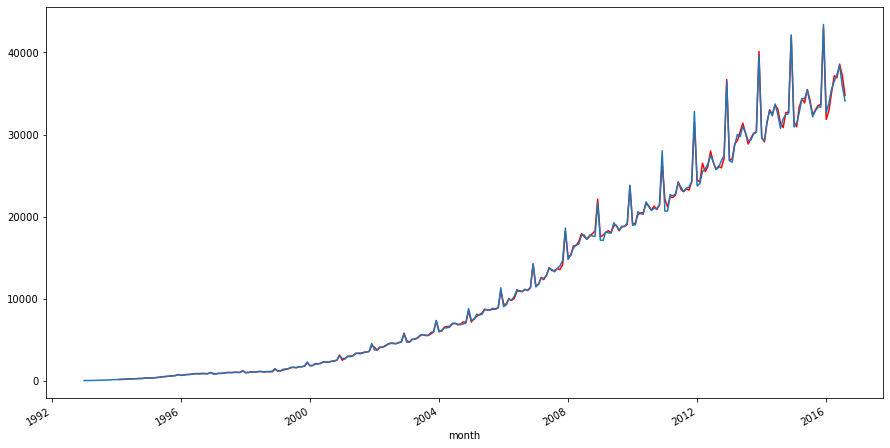

In [26]:
plt.figure(figsize = SIZE_OF_PLOTS)
plt.plot(df_avrge_slry.index.values[13:], df_avrge_slry.model.values[13:], color='r')
df_avrge_slry.WAG_C_M.plot()

## Прогнозирование с помощью финальной модели.

In [27]:
df_avrge_slry.index[-1]

Timestamp('2016-08-01 00:00:00')

In [28]:
salary2 = df_avrge_slry[['WAG_C_M']]

In [29]:
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
start = len(best_model.fittedvalues)
future.WAG_C_M = invboxcox( best_model.predict(start=start, end=start+35), boxcox_lambda)
salary2 = pd.concat([salary2, future])

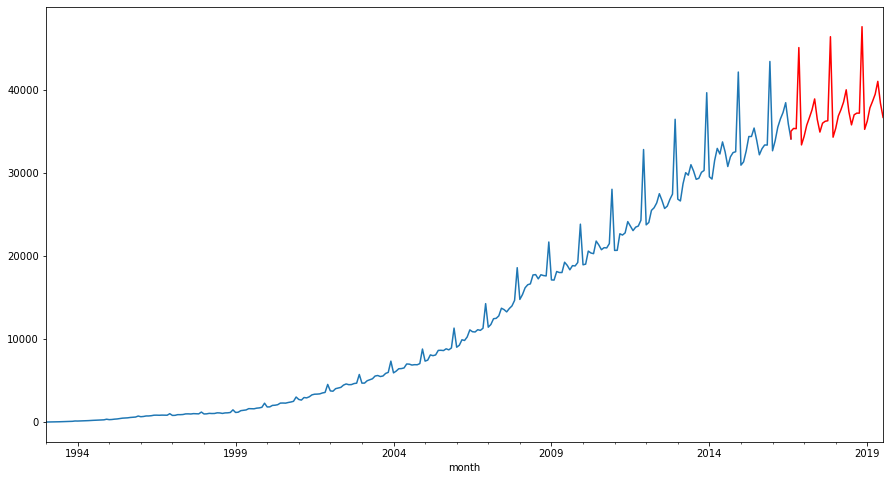

In [30]:
plt.figure(figsize = SIZE_OF_PLOTS)
df_avrge_slry.WAG_C_M.plot()
salary2.WAG_C_M["2016-08-01":].plot(color='r')
plt.show()

<b>P.S.:</b>Педсказания кажутся естественным продолжением исходного временного ряда, что и требовалось получить по условиям задачи. Вероятно интересной альтернативой было бы сравнивать с отложенной выборкой например из 12 или 24 последних месяцев исходного временного ряда. 